In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import random, mlx_lm, math, scipy, pickle
from functools import partial
from itertools import starmap
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

import gemma2

# Introduction

This notebook is a tutorial based on Engels et al. "Not All Language Model Features Are Linear" (https://arxiv.org/abs/2405.14860)

## Setup

Here are some commands to verify that the environment is correctly set up. It will download the model weights and generate some sample text:

In [4]:
model, tokenizer = gemma2.load()
mlx_lm.utils.generate(model, tokenizer, "Hello")

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

',\n\nI have a problem with the following code:\n\n<code>\n#include <iostream>\n#include <string>\n#include <vector>\n#include <algorithm>\n#include <iterator>\n#include <fstream>\n#include <sstream>\n#include <iomanip>\n#include <cmath>\n#include <ctime>\n#include <cstdlib>\n#include <cctype>\n#include <cstring>\n#include <cstdio>\n#'

# Toy Case

The content of this section corresponds to Appendix D in the paper.

## Single Circular Features

In this section we train an (sparse) autoencoder on data points that are distributed uniformly along the unit circle. This serves to build some intution and specify some terms. Feel free to skip this if you feel comfortable with how the basics of how the SAE's work.

*TODO:* what is the take-away here? Maybe add something to show that a single dimension is not sufficient

### Complete Case

We begin with a trivial example to gain basic intuition on the feature vectors of a trained SAE. We generate random samples of points on the unit circle. Then we train a SAE with two features on this data. 

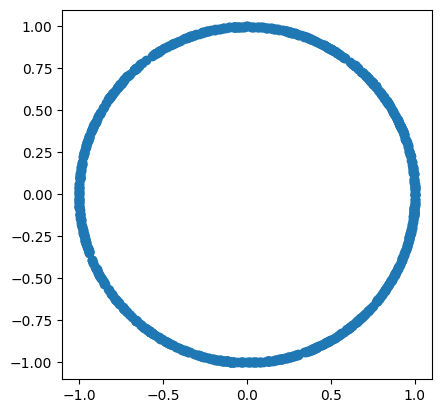

In [3]:
def random_points_on_unit_circle(N, offset=(0, 0)):
  angles = 2 * np.pi * np.random.rand(N)
  x = np.cos(angles) + offset[0]
  y = np.sin(angles) + offset[1]
  return np.column_stack((x, y))

unit_circle_points = random_points_on_unit_circle(1000)
plt.scatter(unit_circle_points[:, 0], unit_circle_points[:, 1])
plt.gca().set_aspect('equal')
plt.show()

In [155]:
class SAE(nn.Module):
  def __init__(self, input_dim, hidden_dim, normalize_dec=False):
    super(SAE, self).__init__()
    self.encoder       = nn.Linear(input_dim, hidden_dim)
    self.decoder       = nn.Linear(hidden_dim, input_dim)
    self.normalize_dec = normalize_dec

  @property
  def dict_elements(self):
    return self.decoder.weight / mx.linalg.norm(self.decoder.weight, axis=0, keepdims=True)

  def __call__(self, x):
    # TOUNDERSTAND: Why do we subtract the bias?
    features = nn.relu(self.encoder(x - self.decoder.bias))
    return features, self.decoder(features)

  def draw_dict_elements(self, plt):
    dict_elements = self.dict_elements
    for i in range(dict_elements.shape[1]):
      plt.quiver(0, 0, dict_elements[0, i], dict_elements[1, i], angles='xy', scale_units='xy', scale=1, color='r')

  def loss_fn(self, X, sparsity_penalty):
    features, reconst = self(X)
    recon_loss        = mx.mean(mx.power(reconst-X, 2), axis=1)
    sparsity_loss     = mx.sum(mx.abs(features), axis=1)
    return mx.mean(recon_loss + sparsity_penalty*sparsity_loss)

  def train(self, Xs, sparsity_penalty, lr=1e-3, max_iter=20000, batch_size=16):
    """
    Xs: list of input datasets, they will be sampled uniformly
    """
    mx.eval(self.parameters())
    loss_and_grad_fn = nn.value_and_grad(self, partial(self.loss_fn, sparsity_penalty=sparsity_penalty))
    optimizer        = optim.Adam(learning_rate=lr)

    if not isinstance(Xs, list):
      Xs = [Xs]

    with tqdm(total=max_iter, desc="Training", unit="iter") as pbar:
      for i in range(max_iter):
        X           = random.choice(Xs)      # why we do this will become clear later
        batch_idx   = np.random.choice(len(X), batch_size)
        x           = mx.array(X[batch_idx])
        loss, grads = loss_and_grad_fn(x)

        if i % 100 == 0:
          pbar.set_postfix({"Loss": loss.item()})

        optimizer.update(self, grads)
        mx.eval(self.parameters(), optimizer.state)

        pbar.update(1)
    

Next we train a SAE which has input and hidden dimension of 2.

Training: 100%|██████████| 20000/20000 [00:19<00:00, 1020.81iter/s, Loss=0.00149]


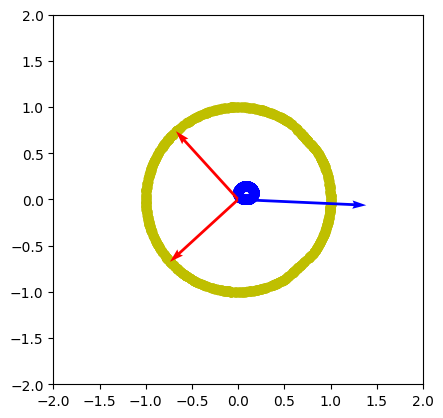

In [140]:
unit_circle_sae = SAE(2, 2)
# Paper uses sparsity penalty of 0.1, this did not work for me. Reconstruction resulted in two lines and a half-circle
# you should be seeing a loss of around 0.02, if it's much higher rerun the training
unit_circle_sae.train(unit_circle_points, sparsity_penalty=0.01, lr=1e-3, batch_size=256)

unit_circle_points_features, unit_circle_points_reconst = unit_circle_sae(mx.array(unit_circle_points))
plt.scatter(unit_circle_points_features[:, 0], unit_circle_points_features[:, 1], color="b")
plt.scatter(unit_circle_points_reconst[:, 0], unit_circle_points_reconst[:, 1], color="y")

unit_circle_sae.draw_dict_elements(plt)
plt.quiver(0, 0, unit_circle_sae.decoder.bias[0], unit_circle_sae.decoder.bias[1], angles='xy', scale_units='xy', scale=1, color='b')

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_aspect('equal')
plt.show()

#### Terminology

* features
* activations
* dictionary elements

#### Over-complete Case

Training: 100%|██████████| 20000/20000 [00:18<00:00, 1098.49iter/s, Loss=0.047] 


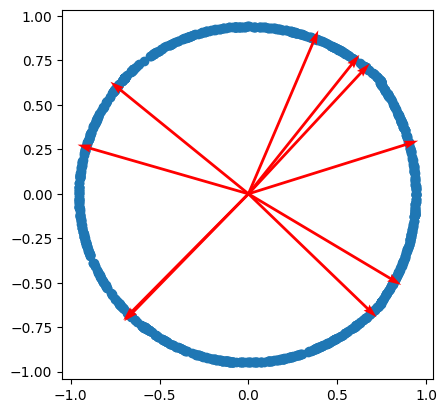

In [54]:
unit_circle_over_complete_sae = SAE(2, 10)
unit_circle_over_complete_sae.train(unit_circle_points, sparsity_penalty=0.1, lr=1e-4, max_iter=20000, batch_size=256)

unit_circle_points_over_complete_features, unit_circle_points_over_complete_reconst = unit_circle_over_complete_sae(mx.array(unit_circle_points))
plt.scatter(unit_circle_points_over_complete_reconst[:, 0], unit_circle_points_over_complete_reconst[:, 1])
unit_circle_over_complete_sae.draw_dict_elements(plt)

plt.gca().set_aspect('equal')
plt.show()

### Details

* investigate the norm of the feature

### Discussion

* SAE's reconstruct the input data
* Not sure what the over-complete case is included in the paper.

Some open questions:
* In the complete case the activations consistently have two flat edges. Why is this?
* Why do the hyperparameters from the paper not reproduce?
* Why is are the activations shifted from the origin in the complete case, but not in the over-complete case?

## Multiple Circular Features

In the previous section we only had one feature which was represented by two directions in feature space. In this next step we want to show how use a SAE to distinguish two such features.

The setup is as follows: We generate two unit circles that we embed in a higher dimensional space (R^10 in this case). We then train a SAE on this data. Assuming that it represents the data well (spoiler: it will), the question is then how do we disentangle the two features based on the internal activations.

Ideally we will two disjoint sets of directions in feature space. Each one corresponding to one of the two circles. Again assuming this to be the case we will apply the following method:
1. cluster the features using the pair-wise angular similarities into two clusters
2. generate a large number of feature activations and for each cluster only retain the input samples that activated at least one feature
3. for each of the input samples set the features that are not in the cluster to zero
4. this should reconstruct the two input circles

In [156]:
def embed_random_points_on_unit_circle(N, M, dims):
    """
    Generate N random points on a unit circle embedded in an M-dimensional space.

    Parameters:
    N (int): Number of points to generate.
    M (int): Dimensionality of the space.
    dims (tuple): Indices of the dimensions in which the circle lies.

    Returns:
    np.ndarray: An array of shape (N, M) containing the random points.
    """
    angles = 2 * np.pi * np.random.rand(N)
    x = np.cos(angles)
    y = np.sin(angles)

    points = np.zeros((N, M))
    points[:, dims[0]] = x
    points[:, dims[1]] = y
    return points

unit_circle1_in_high_dimensions = embed_random_points_on_unit_circle(1000, 10, (0, 1))
unit_circle2_in_high_dimensions = embed_random_points_on_unit_circle(1000, 10, (2, 3))

high_dimensions_sae = SAE(10, 64)
high_dimensions_sae.train([unit_circle1_in_high_dimensions, unit_circle2_in_high_dimensions], sparsity_penalty=0.01, lr=1e-3, batch_size=128)

Training: 100%|██████████| 20000/20000 [00:21<00:00, 941.67iter/s, Loss=0.00109]


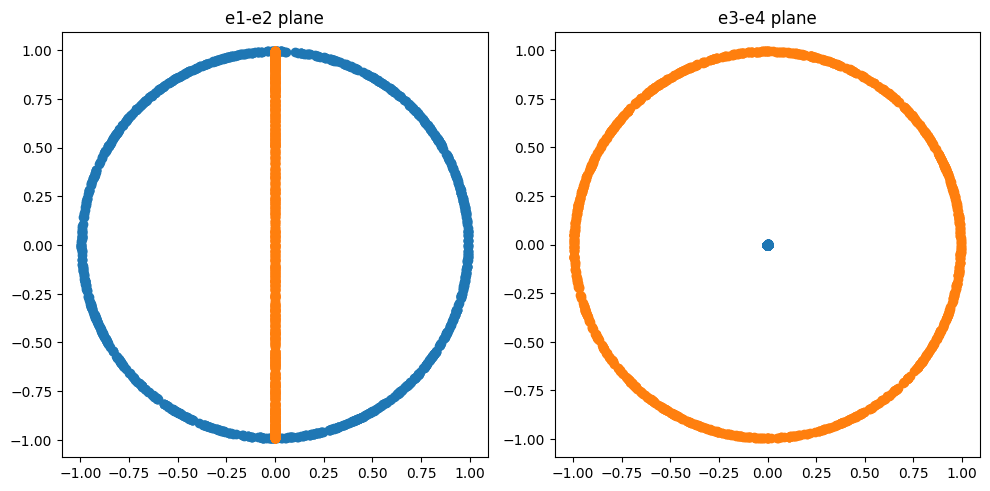

In [157]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

recon_unit_circle1_in_high_dimensions = high_dimensions_sae(mx.array(unit_circle1_in_high_dimensions))[1]
recon_unit_circle2_in_high_dimensions = high_dimensions_sae(mx.array(unit_circle2_in_high_dimensions))[1]

axs[0].scatter(recon_unit_circle1_in_high_dimensions[:, 0], recon_unit_circle1_in_high_dimensions[:, 1])
axs[0].scatter(recon_unit_circle2_in_high_dimensions[:, 0], recon_unit_circle1_in_high_dimensions[:, 1])
axs[0].set_aspect('equal')
axs[0].set_title('e1-e2 plane')

axs[1].scatter(recon_unit_circle1_in_high_dimensions[:, 2], recon_unit_circle1_in_high_dimensions[:, 3])
axs[1].scatter(recon_unit_circle2_in_high_dimensions[:, 2], recon_unit_circle2_in_high_dimensions[:, 3])
axs[1].set_aspect('equal')
axs[1].set_title('e3-e4 plane')

plt.tight_layout()
plt.show()

We continue looking only at alive features. The goal of the sparse autoencoder is to learn a sparse dictionary. That means for most inputs only a small number of features should be active, ie have a magnitude > 0. To find these we take our input data and generate a large number of feature activations to observe which dimensions are activated.

*Think about* what are the requirements for the input data to determine alive features.

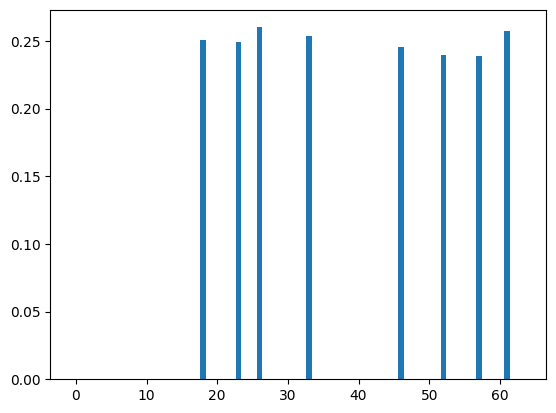

In [158]:
high_dimensions_activations = high_dimensions_sae(mx.concatenate([mx.array(unit_circle1_in_high_dimensions), mx.array(unit_circle2_in_high_dimensions)]))[0]
high_dimensions_active_frac = np.array(mx.mean(mx.abs(high_dimensions_activations) > 1e-8, axis=0))
high_dimensions_active_idxs = np.where(high_dimensions_active_frac > 1e-8)[0]
plt.bar(np.arange(64), high_dimensions_active_frac)
plt.show()

We start with a sanity check. The input data is aligned to two planes, therefore if we got a clean separation between the two features we should see two planes in the activations.

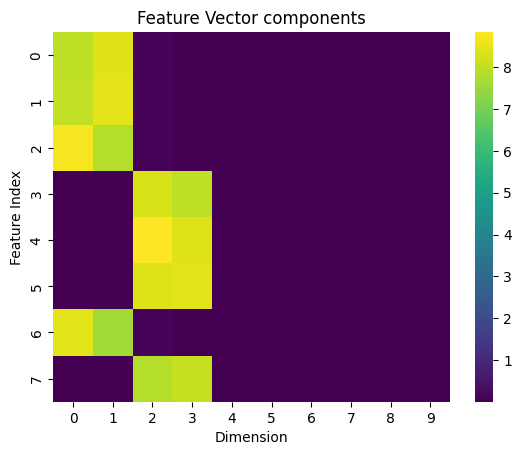

In [195]:
high_dimensions_sae_alive_features = np.array(high_dimensions_sae.decoder.weight)[:, high_dimensions_active_idxs]
sns.heatmap(np.abs(high_dimensions_sae_alive_features.T), annot=False, cmap='viridis', linewidths=0)
plt.title('Feature Vector components')
plt.xlabel('Dimension')
plt.ylabel('Feature Index')
plt.show()

In the graph above we clearly see that the feature vectors are mostly aligned with e1-e2 & e3-e4 basis vectors.

Now we proceed to cluster the feature vectors in the paper this is done using cosine similarity. I was not able to reproduce this. In the paper the number of alive features (Figure 11) is much larger ie around 35 vs. 8 in the above. To proceed we use a different clustering based on Jaccard similarity (also known as IOU similarity). This is also mentioned in the paper, but not used in this case.

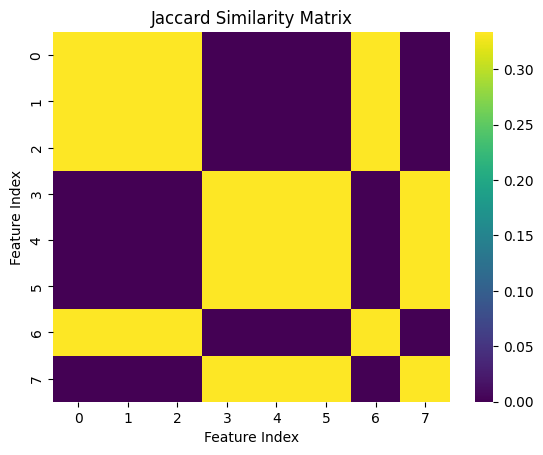

In [174]:
def jaccard_matrix(X):
  intersection = np.dot(X, X.T)
  union        = X.sum(axis=1, keepdims=True) + X.sum(axis=1) - intersection
  return intersection / union

sns.heatmap(jaccard_matrix(np.abs(high_dimensions_sae_alive_features.T) > 0.1), annot=False, cmap='viridis', linewidths=0)
plt.title('Jaccard Similarity Matrix')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.show()

In [199]:
from sklearn.cluster import AgglomerativeClustering

high_dimensions_feature_clustering = AgglomerativeClustering(n_clusters=2)
high_dimensions_feature_clustering.fit(1 - jaccard_matrix(np.abs(high_dimensions_sae_alive_features.T) > 0.1))

high_dimension_zero_features_idxs = high_dimensions_active_idxs[high_dimensions_feature_clustering.labels_ == 0]
high_dimension_one_features_idxs  = high_dimensions_active_idxs[high_dimensions_feature_clustering.labels_ == 1]

# get the plane for the two clusters. We do this by getting the indices of the two largest components of the feature vectors
def topk_component_idx(features, k):
  c = np.sum(np.abs(features), axis=0)
  return np.argsort(c)[-k:]

high_dimension_zero_plane = topk_component_idx(np.array(high_dimensions_sae.decoder.weight).T[high_dimension_zero_features_idxs], 2)
high_dimension_one_plane  = topk_component_idx(np.array(high_dimensions_sae.decoder.weight).T[high_dimension_one_features_idxs], 2)

Using the clustering we now have two sets of vectors that correspond to the two features, ie the two unit circles of our input data. We now show that these feature clusters are sufficient to reconstruct the relevant features of the input data.

The approach is the following:
1. in activations we used to identify the alive features, we now search for all samples that activate at least one of the features in a cluster. We ignore any samples that activate no feature.
2. for each activation, we set the features that are not in the cluster to zero
3. then reconstruct the input using the weights and bias from the decoder

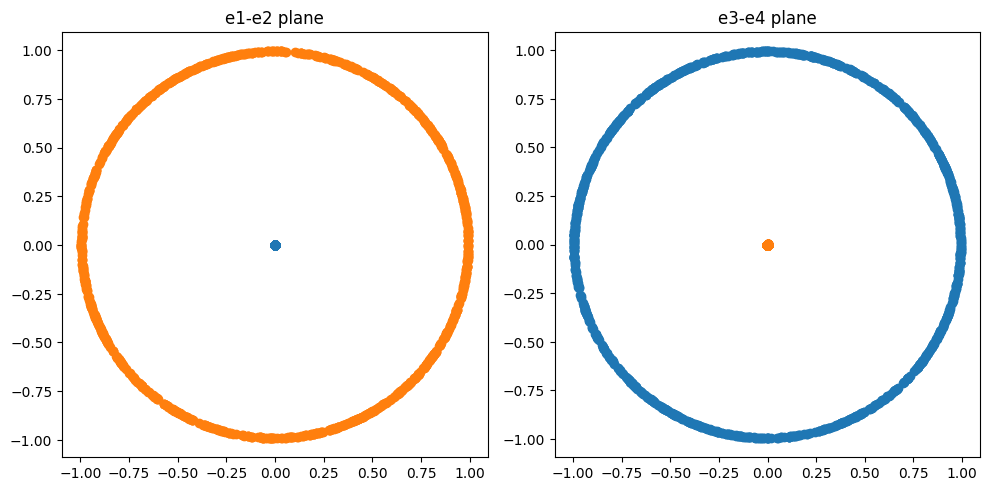

In [218]:
# find all the activations that activate at least one of the features in each cluster, create a copy of the array
high_dimension_zero_samples_idxs = np.where(np.sum(np.array(high_dimensions_activations)[:, high_dimension_zero_features_idxs], axis=1) > 0.01)[0]
high_dimension_one_samples_idxs  = np.where(np.sum(np.array(high_dimensions_activations)[:, high_dimension_one_features_idxs], axis=1) > 0.01)[0]
high_dimension_zero_activations  = np.array(high_dimensions_activations)[high_dimension_zero_samples_idxs].copy()
high_dimension_one_activations   = np.array(high_dimensions_activations)[high_dimension_one_samples_idxs].copy()

# find the indices of all features not part of each cluster and set them to zero in the activations copy
high_dimension_not_zero_features_idxs = np.setdiff1d(np.arange(high_dimensions_activations.shape[1]), high_dimension_zero_features_idxs)
high_dimension_not_one_features_idxs  = np.setdiff1d(np.arange(high_dimensions_activations.shape[1]), high_dimension_one_features_idxs)
high_dimension_zero_activations[:, high_dimension_not_zero_features_idxs] = 0
high_dimension_one_activations[:, high_dimension_not_one_features_idxs]   = 0

# reconstruct & plot the samples
high_dimensions_zero_reconst = high_dimensions_sae.decoder(mx.array(high_dimension_zero_activations))
high_dimensions_one_reconst  = high_dimensions_sae.decoder(mx.array(high_dimension_one_activations))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(high_dimensions_zero_reconst[:, 0], high_dimensions_zero_reconst[:, 1])
axs[0].scatter(high_dimensions_one_reconst[:, 0], high_dimensions_one_reconst[:, 1])
axs[0].set_aspect('equal')
axs[0].set_title('e1-e2 plane')

axs[1].scatter(high_dimensions_zero_reconst[:, 2], high_dimensions_zero_reconst[:, 3])
axs[1].scatter(high_dimensions_one_reconst[:, 2], high_dimensions_one_reconst[:, 3])
axs[1].set_aspect('equal')
axs[1].set_title('e3-e4 plane')

plt.tight_layout()
plt.show()

# Theory

# Clustering the SAEs in a LM

we make use of the google trained SAE for gemma 2 to find some irreducible features.

In [1]:
def graph_clustering(layer, width, l0, cutoff, topk):
  def extract_adjacency():
    sae       = gemma2.JumpReLUSAE.load(layer=layer, width=width, l0=l0)
    all_sims  = sae.W_dec @ sae.W_dec.T       # all dictionary elements are normalized to unit length
    neigh_idx = np.argsort(all_sims, axis=1)[:, -1*(topk+1):-1]

    # construct the adjacency matrix for an undirected graph
    adjacency = np.zeros_like(all_sims)
    for i, row in enumerate(neigh_idx):
      adjacency[i, row] = 1
      adjacency[row, i] = 1
    # now remove all edges with similarity below the cutoff
    adjacency[all_sims < cutoff] = 0
    return adjacency

  def find_connected_components(adjacency):
    "Depth-first-search to find connected components in the graph"

    def dfs(node, adjacency, visited, component):
      stack = [node]
      while stack:
        node = stack.pop()
        if not visited[node]:
          visited[node] = True
          component.append(node)
          stack.extend([neighbor for neighbor in range(len(adjacency[node])) if adjacency[node][neighbor] == 1 and not visited[neighbor]])

    num_nodes  = len(adjacency)
    visited    = [False] * num_nodes
    components = []
    for node in tqdm(list(range(num_nodes))):
      if not visited[node]:
        component = []
        dfs(node, adjacency, visited, component)
        components.append(component)
    return components

  return [c for c in find_connected_components(extract_adjacency()) if len(c) > 2]

The above above clustering will give us sets of possibly related features. We however have no idea of what a cluster corresponds to. To understand the meaning of a cluster of dictionary elements we will have to manually inspect it using a visualization function that we implement below.

Before presenting the implementation we will discuss the intuition behind the visualization. First of all we are looking for simple concepts that can be represented by single words. The example we will be working with in the rest of the tutorial are weekdays and months. These can be considered to be arranged on a circle, as we will see later on. Luckily weekdays are common enough that they are represented as individual tokens by the language model.

We will characterise a cluster of features by the tokens that most consistently and strongly activate it. To that end we will generate the feature activations on a large dataset. Then for each feature and token combination we calculate the mean activation and the standard deviation. If a token is consistently activating a feature it will have a high mean activation. If the concept captured by a feature is enapsulated in a single word then we expect the standard deviation of the activations to be low. On the other hand for concepts that are context dependent we would expect the activation associated with a particular token to vary a lot, depending on the surrounding tokens, the ones that we are ignoring for this analysis.

## Technical details of generating activations data

Generating these activations is computationally expensive. For this tutorial activation data was pre-calculated and made available on Huggingface (https://huggingface.co/datasets/derfred/multi_dimensional_features_tutorial). If you wish to regenerate the data you can use the scripts `prepare_activations.py` & `activation_stats.py` in this repository. The data for the rest of the tutorial was generated with the following parameters:
* About 47 million (256*4096*45) tokens from the dataset monology/pile-uncopyrighted with context length of 256
* Activations from Gemma 2 9b in 8bit quantization
* Hidden layer activations from the residual stream in layer 5
* The GemmaScope SAE's were used in particular with width 16k and L0 of 37
* Store only the top 64 activations for each token

The `prepare_activations.py` script will output a set of .npz files containing the feature activations. Each file contains the following numpy arrays:
* llm_tokens - shape (split_size, context_size) - the tokens that were used to generate the activations
* sae_idxs - shape (split_size, context_size, top_k_features) - the indices of the features that were activated
* sae_acts - shape (split_size, context_size, top_k_features) - the value of the activations of the features that were activated

The `activation_stats.py` script will analyse the activations and calculate the intermediate data to calcualate the standard deviation for a set of token-feature pairs. The output is a .pkl file containing the following Python arrays, that are each of length `num_features`:
* tok_idxs - for each of feature an array of tokens that activate it
* tok_acts - for each of feature an array of activations, which correspond to the tokens in tok_idxs
* tok_mns  - for each of feature an array of mean activations, which correspond to the tokens in tok_idxs
* tok_m2s  - for each of feature an array of M2 values, which correspond to the tokens in tok_idxs

The M2 values are the sum of the squared differences from the mean. They are an intermediate value in [Welford's Algorithm](https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm)

In [8]:
def plot_cluster_activations(cluster, layer, width, l0, topk=50):
  with open(f"feature_token_stats_layer_{layer}_width_{width}_l0_{l0}.pkl", "rb") as f:
    tok_idxs, tok_cnts, tok_mns, tok_m2s = pickle.load(f)

  # reconstruct the part of the feature-token activation matrix relevant to this cluster
  feat_counts = np.zeros((len(cluster), 256128), dtype=np.int32)
  feat_means  = np.zeros((len(cluster), 256128), dtype=np.float32)
  feat_m2s    = np.zeros((len(cluster), 256128), dtype=np.float32)
  for i, feat in enumerate(cluster):
    feat_counts[i, tok_idxs[feat]] = tok_cnts[feat]
    feat_means[i, tok_idxs[feat]]  = tok_mns[feat]
    feat_m2s[i, tok_idxs[feat]]    = tok_m2s[feat]

  # calculate the mean and standard deviation using Welford's Algorithm https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm
  eps    = 1e-10
  counts = np.sum(feat_counts, axis=0)
  means  = np.sum(feat_counts * feat_means, axis=0) / (counts + eps)
  m2s    = np.sum(feat_m2s + feat_counts * (feat_means - means)**2, axis=0)
  stdevs = np.sqrt(m2s / (counts - 1 + eps))

  # plot the topk tokens with the highest mean activation for the features in the cluster
  # the shaded region represents the standard deviation
  # also output the detokenized strings as labels
  top_feat_idxs = np.argsort(means)[::-1]
  plt.figure(figsize=(10,6))
  plt.plot(means[top_feat_idxs][:topk])
  plt.fill_between(range(topk), (means - stdevs)[top_feat_idxs][:topk], (means + stdevs)[top_feat_idxs][:topk], color='b', alpha=0.1)

  for i, tok in enumerate(top_feat_idxs[:topk]):
      plt.annotate(tokenizer.decode([tok]), (i, means[top_feat_idxs][i]), 
                  xytext=(5, 5), textcoords='offset points', 
                  rotation=45, ha='left', va='bottom', fontsize=8)
  plt.show()

For the purpose of this tutorial we identified some features that are activated by weekdays. We will now visualize it using our `plot_cluster_activations` function:

100%|██████████| 16384/16384 [03:34<00:00, 76.55it/s]


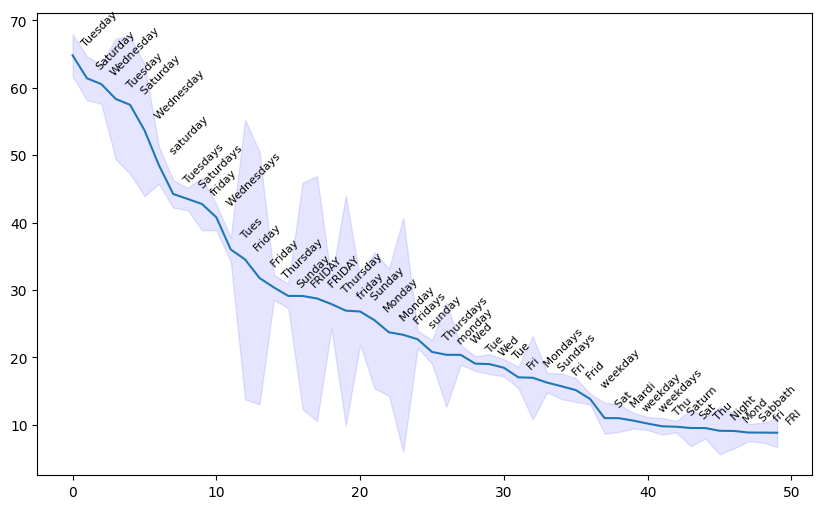

In [7]:
clusters_from_graph = graph_clustering(layer=5, width="16k", l0=37, cutoff=0.5, topk=2)
weekdays_cluster    = next(c for c in clusters_from_graph if len(set(c) & set([4203,  7881,  2350, 13120,  2188,  1004])) > 0)
plot_cluster_activations(weekdays_cluster, topk=50, layer=5, width="16k", l0=37)

In the above plot you see that the top 50 tokens by mean activation are the english names of the weekdays, along with some abbreviations like "Mon" and a few non-english weekday names like "Mardi". We also see that the standard deviation is generally quite low, indicating that the concept of a weekday is well captured by the feature.

### Excercises

Here are some exercises based on the content and data provided so far:

1. Use the `plot_cluster_activations` to find some more interesting clusters. Call it with the individual elements of the `clusters_from_graph` list. Can you visually identify what makes an "interesting" cluster?
2. Can you find a heuristic for identifying interesting clusters? Try to formalise the intuition behind the visualisation.
3. Implement a function to cluster based on Jaccard distance, instead of the cosine similarity. This will require a lot of computation. What other interesting clusters can you find?

# Circular Features in LMs

We now come to the first main result of the paper.
* Describe the context of the paper, ie past work (ie. the original Anthropic paper on dictionary learning) modelled the features as "linear"
* Link to the response by the Anthropic team to the Engels paper (https://transformer-circuits.pub/2024/july-update/index.html#linear-representations)
* We now look at two sets of features that are encoded in a circular manner in the residual stream of a LM. These are the weekdays and the months.
* The paper used GPT-2 & Mistral 7B as the LMs to investigate.
* In this tutorial we use Gemma 2 9B as the LM. After the Engels paper was published, Google Deepmind released a full set of SAE's for the Gemma 2 model.
* The reason for using these SAE's as opposed to the original LMs are 1. to verify if the results also apply to Gemma 2 and 2. having SAE's for all layers allows continuing the study over the full transformer stack.

## Task

Describe the week/month math task

In [6]:
NUMBERS  = ["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine", "Ten", "Eleven", "Twelve"]
WEEKDAYS = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
MONTHS   = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

def promptfn(domain):
  def hook_outputs(fn, hook, prompts=None):
    def apply(tokens):
      hook.reset()
      model(tokens[None], hook=hook)
      return hook.output
    tokenized_prompts = fn.tokenized_prompts if prompts is None else [tokenizer.encode(prompt) for prompt in prompts]
    return np.array([apply(mx.array(tokens)) for tokens in tokenized_prompts])

  def model_outputs(fn, hook=None):
    return np.array([model(mx.array(tokens)[None], hook=hook)[0, -1, :] for tokens in fn.tokenized_prompts])

  def decorator(fn):
    fn.count         = len(domain)
    fn.domain        = domain
    fn.domain_tokens = [tokenizer.encode(i)[-1] for i in domain]
    assert [tokenizer.decode(i).strip() for i in fn.domain_tokens] == domain

    # next two variables encode the calendar math problems in the following order:
    # [(0, 0), (0, 1), ..., (0, count-1), (1, 0), ..., (1, count-1), ..., (count-1, count-1)]
    fn.a_values = np.hstack([np.array([i] * fn.count) for i in range(fn.count)])
    fn.offsets  = np.hstack([np.arange(fn.count) for _ in range(fn.count)])
    fn.c_values = (fn.a_values+fn.offsets) % fn.count

    fn.prompts           = [fn(a_token, offset) for a_token, offset in zip(fn.a_values, fn.offsets)]
    fn.tokenized_prompts = [tokenizer.encode(prompt) for prompt in fn.prompts]

    fn.hook_outputs  = partial(hook_outputs, fn)
    fn.model_outputs = partial(model_outputs, fn)

    # find the index of the placeholder token
    fn.a_index = [tokenizer.decode(t).strip() for t in tokenizer.encode(fn(0, 1))].index(domain[0])
    return fn
  return decorator

@promptfn(WEEKDAYS)
def week_prompt(start, offset):
  suffix = "" if offset == 1 else "s"
  return f"Let's do some day of the week math. {NUMBERS[offset]} day{suffix} from {WEEKDAYS[start]} is"

@promptfn(MONTHS)
def month_prompt(start, offset):
  suffix = "" if offset == 1 else "s"
  return f"Let's do some calendar math. {NUMBERS[offset]} month{suffix} from {MONTHS[start]} is"

# TODO make use of the model_outputs function to evaluate the model on the prompts
def calendar_math_eval_and_show(fn):
  def eval(start, offset):
    tokens = mx.array(tokenizer.encode(fn(start, offset)))
    result = tokenizer.decode(mx.argmax(model(tokens[None])[0, -1, :], axis=-1).item()).strip()
    return fn.domain.index(result), result

  X, Y          = np.meshgrid(np.arange(fn.count), np.arange(fn.count), indexing='ij')
  actual, names = np.vectorize(eval)(X, Y)
  expected      = np.stack([np.roll(np.arange(fn.count), -i) for i in range(fn.count)])
  correct       = actual == expected

  df = pd.DataFrame(names)
  def highlight_cells(val):
    return np.where(correct, "", 'background-color: orange; color: black')
  print(f"Correct: {np.sum(correct)}/{correct.shape[0]*correct.shape[1]} {round(np.sum(correct)/float(correct.shape[0]*correct.shape[1])*100, 2)}%")
  return df.style.apply(highlight_cells, axis=None)

In [18]:
calendar_math_eval_and_show(week_prompt)

Correct: 30/49 61.22%


,0,1,2,3,4,5,6
0,Monday,Tuesday,Wednesday,Thursday,Friday,Friday,Saturday
1,Tuesday,Wednesday,Thursday,Friday,Saturday,Saturday,Saturday
2,Wednesday,Thursday,Friday,Saturday,Saturday,Sunday,Tuesday
3,Thursday,Friday,Saturday,Sunday,Sunday,Monday,Tuesday
4,Friday,Saturday,Sunday,Tuesday,Tuesday,Tuesday,Tuesday
5,Saturday,Sunday,Tuesday,Wednesday,Wednesday,Wednesday,Wednesday
6,Sunday,Monday,Tuesday,Wednesday,Wednesday,Thursday,Wednesday


In [8]:
calendar_math_eval_and_show(month_prompt)

Correct: 144/144 100.0%


,0,1,2,3,4,5,6,7,8,9,10,11
0,January,February,March,April,May,June,July,August,September,October,November,December
1,February,March,April,May,June,July,August,September,October,November,December,January
2,March,April,May,June,July,August,September,October,November,December,January,February
3,April,May,June,July,August,September,October,November,December,January,February,March
4,May,June,July,August,September,October,November,December,January,February,March,April
5,June,July,August,September,October,November,December,January,February,March,April,May
6,July,August,September,October,November,December,January,February,March,April,May,June
7,August,September,October,November,December,January,February,March,April,May,June,July
8,September,October,November,December,January,February,March,April,May,June,July,August
9,October,November,December,January,February,March,April,May,June,July,August,September


## Circular Representation of Weekdays & Months

In [8]:
class ExtractResidualStreamHook:
  def __init__(self, tokenidx):
    self.tokenidx = int(tokenidx)
    self.reset()

  @property
  def output(self):
    return np.concatenate(self._acts)

  def reset(self):
    self._acts = []

  def __call__(self, array, label=None):
    if label is not None and label.endswith("resid_post"):
      self._acts.append(np.array(array[:, self.tokenidx]))
    return array

def extract_residual_streams(promptfn):
  return promptfn.hook_outputs(ExtractResidualStreamHook(promptfn.a_index))

def extract_pca_of_residuals(promptfn, k):
  """
    Extracts the residual stream at every layer for each problem in the given task. Apply PCA to the residuals
  """
  # rearrange to be (layer, problem, hidden_dimension)
  residuals = np.transpose(extract_residual_streams(promptfn), (1, 0, 2))

  from sklearn.decomposition import PCA
  pcas = np.array([PCA(n_components=k).fit(residual) for residual in residuals])
  acts = np.array([pca.transform(residual) for pca, residual in zip(pcas, residuals)])

  return acts, pcas

def plot_residual_stream_pcas(residual_stream, number_of_items, number_of_layers=None):
  from sklearn.decomposition import PCA

  layers   = np.linspace(0, model.num_hidden_layers-1, number_of_layers or model.num_hidden_layers, dtype=int)
  num_rows = math.ceil(len(layers) / 3)
  fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

  for i, ax in zip(layers, axs.flatten()):
    pca_acts = PCA(n_components=2).fit_transform(residual_stream[:, i]).reshape(number_of_items, number_of_items, 2)
    for j in range(number_of_items):
      ax.scatter(pca_acts[j, :, 0], pca_acts[j, :, 1])
    ax.set_title(f"Layer {i}")

  plt.tight_layout()
  plt.show()

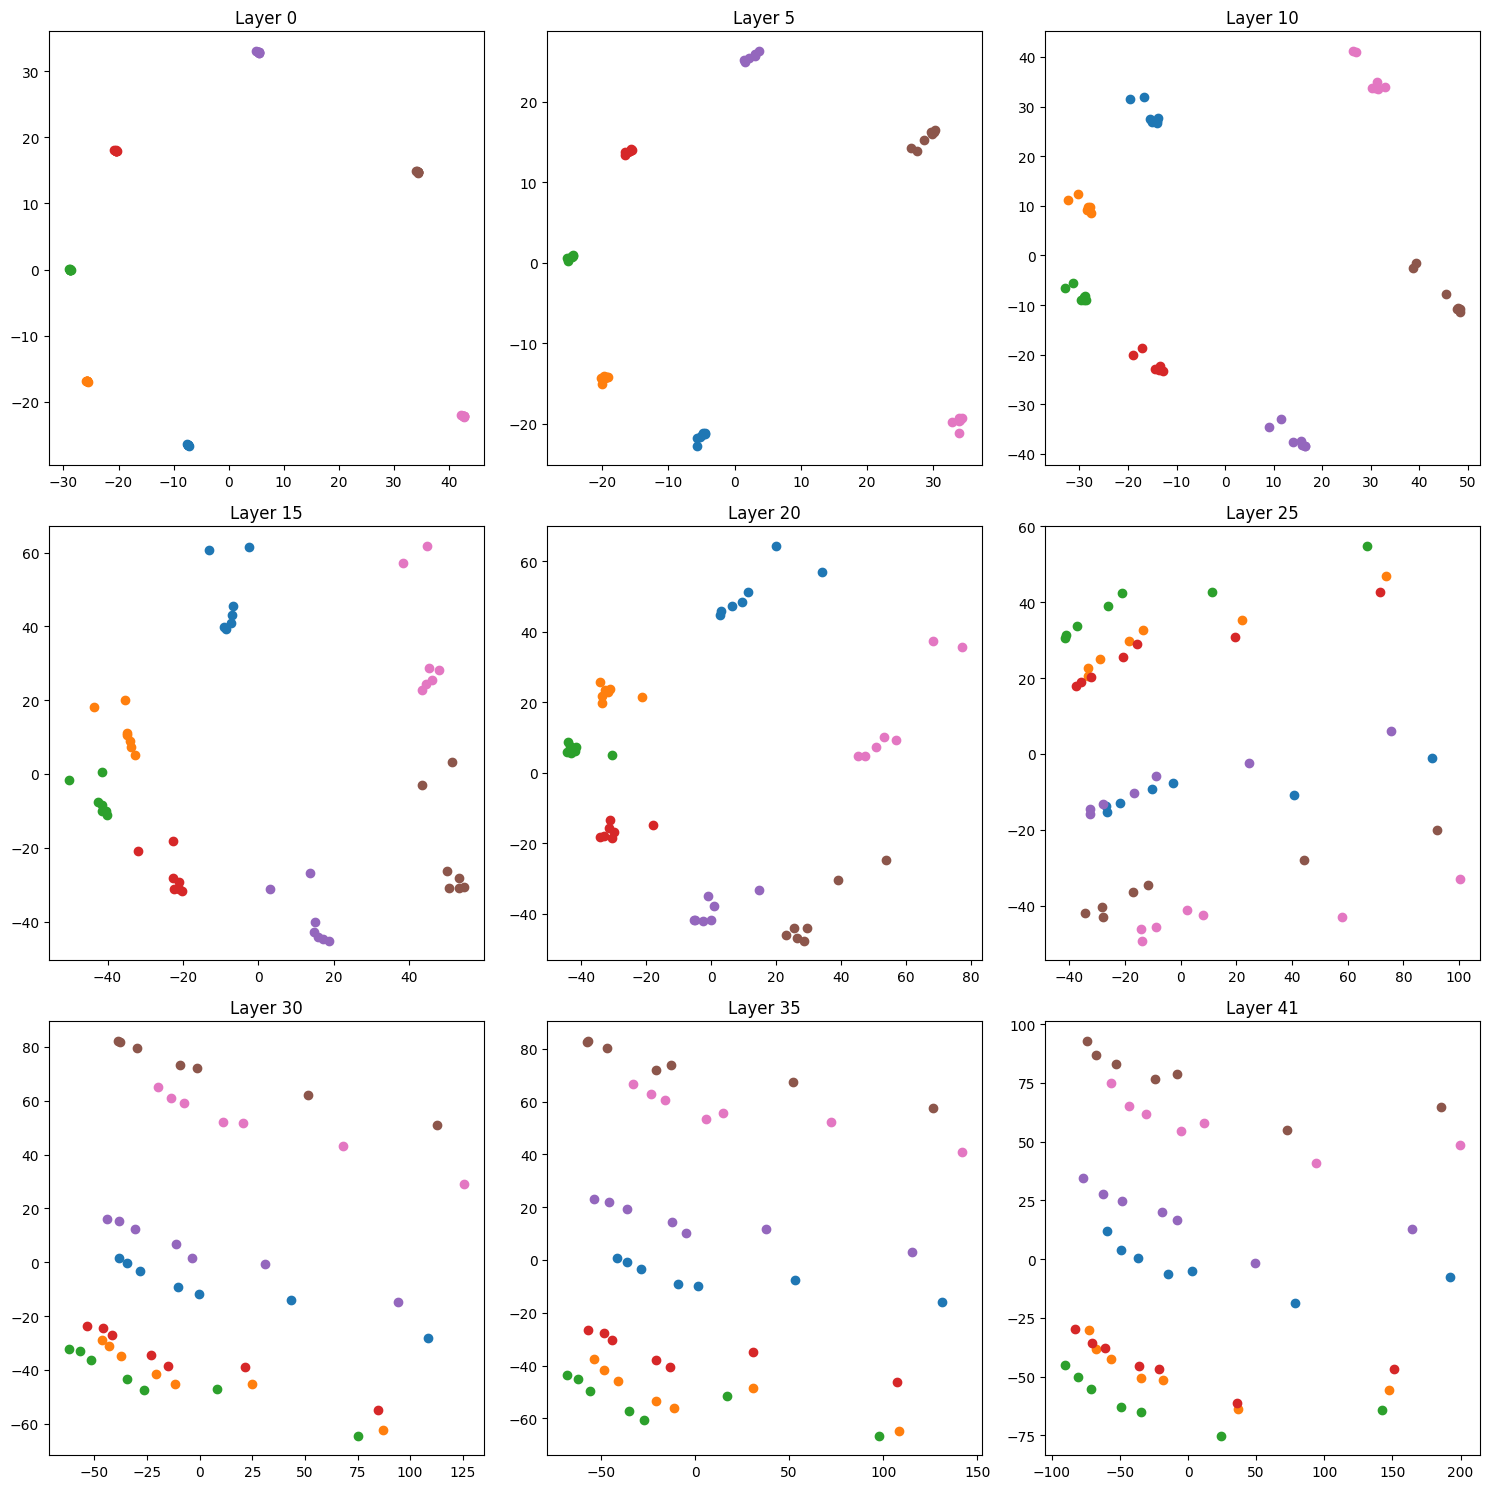

In [113]:
plot_residual_stream_pcas(extract_residual_streams(week_prompt), 7, number_of_layers=9)

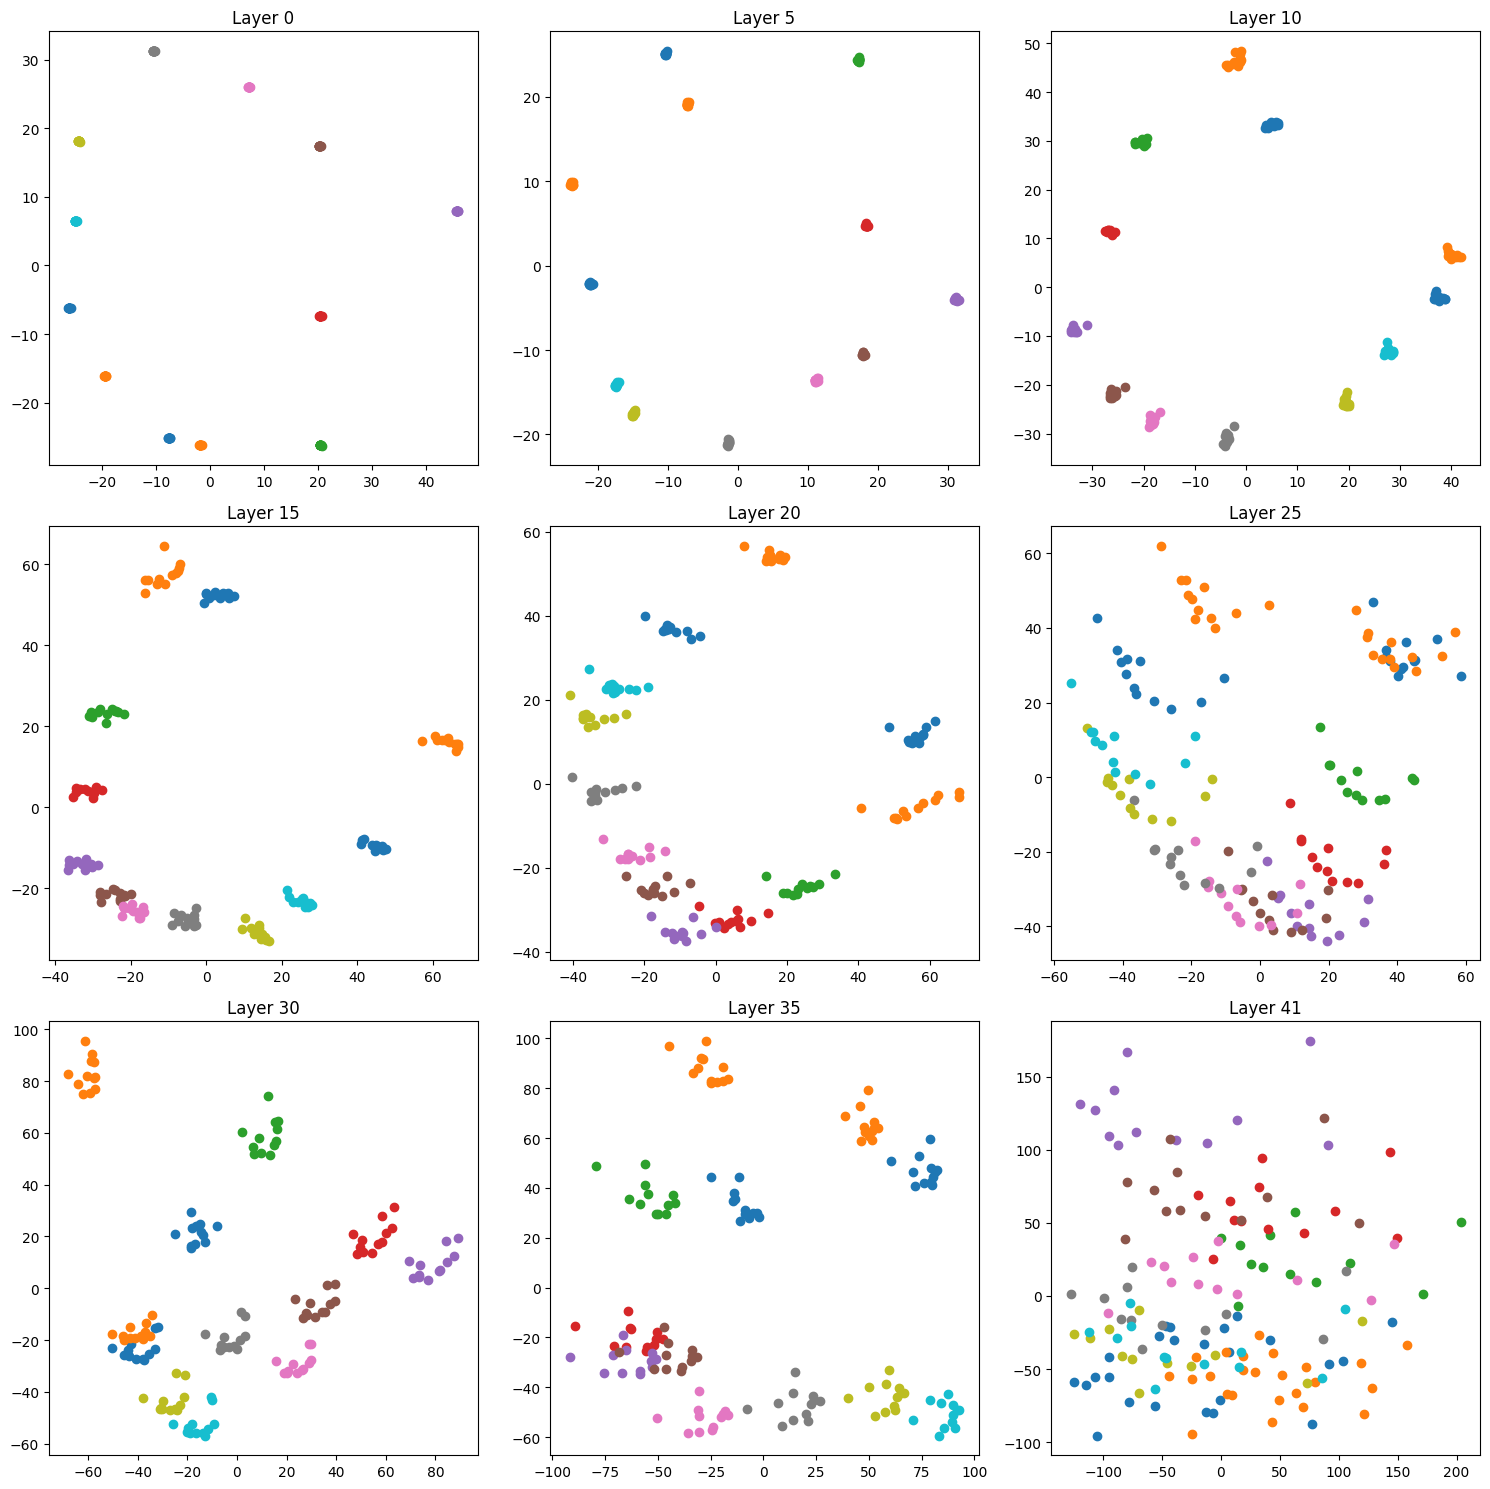

In [64]:
plot_residual_stream_pcas(extract_residual_streams(month_prompt), 12, number_of_layers=9)

Questions:
* circular representation seems to originate in the embedding, then it is slowly lost over the layers?
** the paper state the linearity is caused by the offset number, try some different prompts

# Intervention on Circular Features

We want to show that the circular representation is causally related to the production of the output token. We do this using activation patching
* Explain activation patching
* explain the process involved

Questions:
* does it matter if the model computed the correct result?

## Find the linear probe

In [157]:
def train_linear_probes(promptfn):
  # extract the residual streams and apply PCA to them, shape (layer, problem, hidden_dimension)
  residuals = np.transpose(extract_residual_streams(promptfn), (1, 0, 2))

  from sklearn.decomposition import PCA
  pcas = np.array([PCA(n_components=5).fit(residual) for residual in residuals])
  acts = np.array([pca.transform(residual) for pca, residual in zip(pcas, residuals)])

  # setup $count number of points equally distributed on the unit circle
  w      = 2 * np.pi / promptfn.count
  circle = np.array([np.cos(w * promptfn.a_values), np.sin(w * promptfn.a_values)]).T

  # find the best fit of the PCA components to the circle, the arg min in equation 5
  probes = np.array([np.linalg.lstsq(acts[i], circle, rcond=None)[0] for i in range(model.num_hidden_layers)])

  return probes, pcas, acts

In [158]:
week_linear_probes, week_intermediate_pcas, week_pca_acts    = train_linear_probes(week_prompt)
month_linear_probes, month_intermediate_pcas, month_pca_acts = train_linear_probes(month_prompt)

In [7]:
def visualize_linear_probes(probes, pca_acts, number_of_items, number_of_layers=None):
  layers   = np.linspace(0, model.num_hidden_layers-1, number_of_layers or model.num_hidden_layers, dtype=int)
  num_rows = math.ceil(len(layers) / 3)

  w      = 2 * np.pi / number_of_items
  circle = np.array([np.cos(w * np.arange(number_of_items)), np.sin(w * np.arange(number_of_items))])

  fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
  for i, ax in zip(layers, axs.flatten()):
    # draw the big transparent dots for the ideal circle
    ax.scatter(circle[0], circle[1], s=1000, alpha=0.1)

    # split the PCA's into the groupings for the problems ie. (0, 0), (0, 1), ..., (0, count-1), (1, 0), ..., (1, count-1), ..., (count-1, count-1)
    # then project each grouping into the circle space and plot
    layer_pca_acts = pca_acts[i].reshape(number_of_items, number_of_items, -1)
    for j in range(number_of_items):
      projected_pca_acts = layer_pca_acts @ probes[i]
      ax.scatter(projected_pca_acts[j, :, 0], projected_pca_acts[j, :, 1])

    ax.set_title(f"Layer {i}")
  plt.tight_layout()
  plt.show()

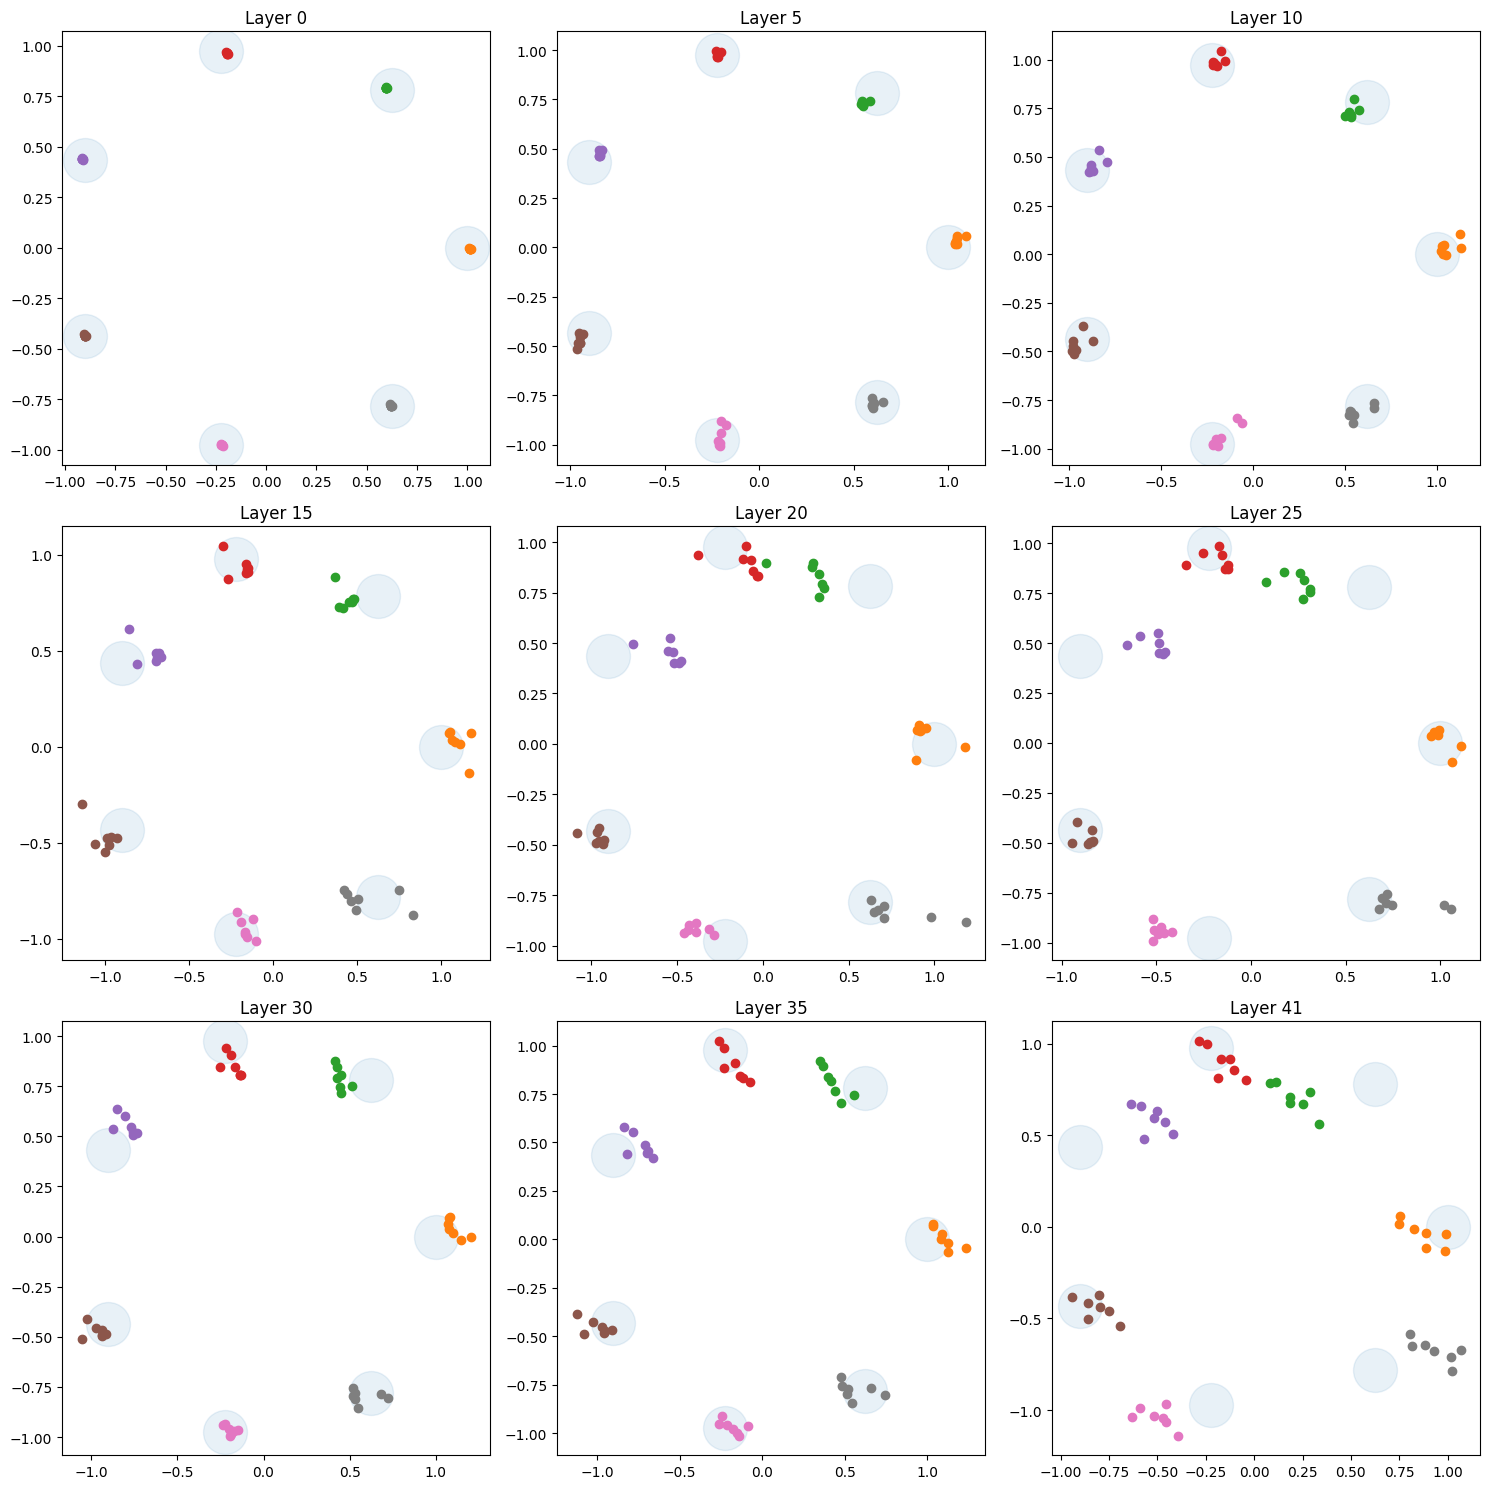

In [54]:
visualize_linear_probes(week_linear_probes, week_pca_acts, 7, number_of_layers=9)

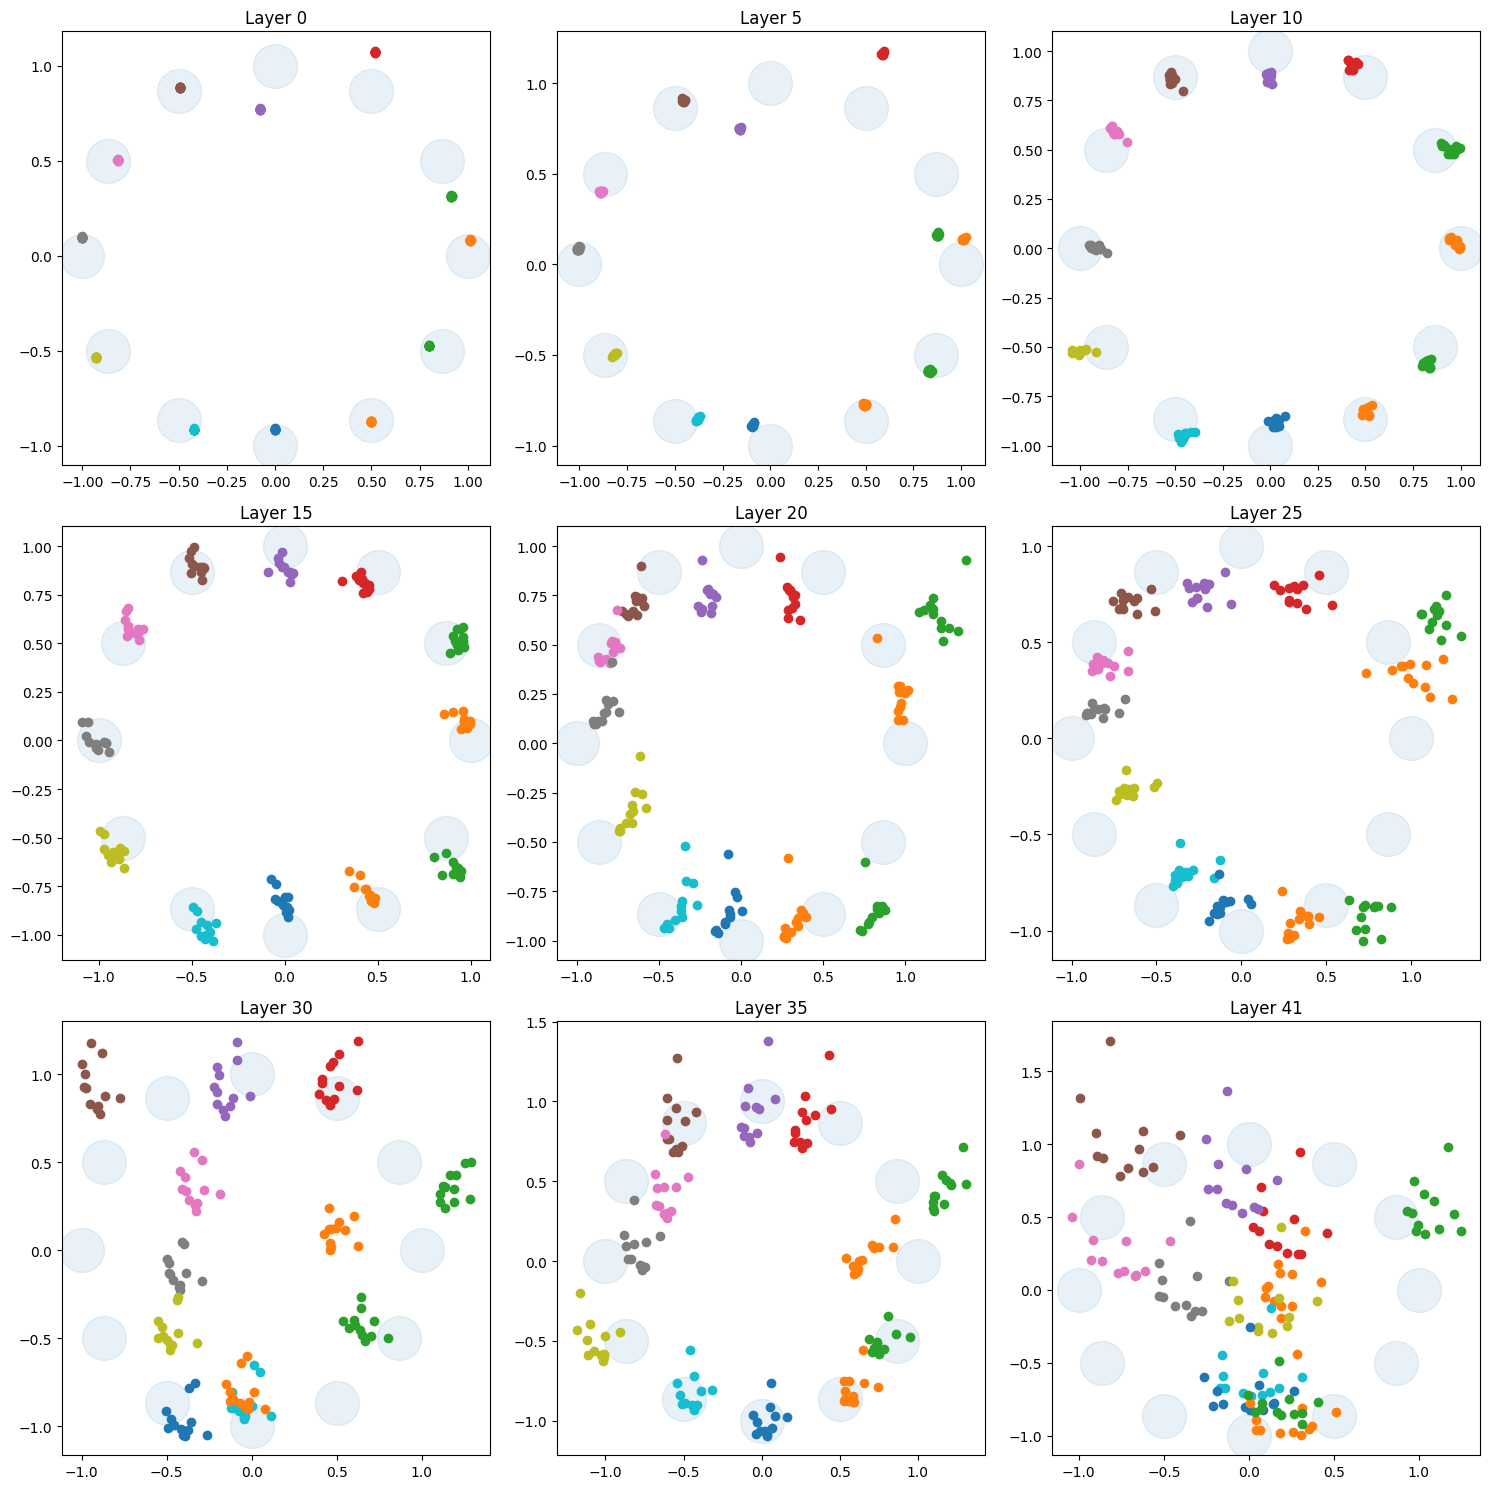

In [55]:
visualize_linear_probes(month_linear_probes, month_pca_acts, 12, number_of_layers=9)

Questions:
* Why did we do the intermediate step of projecting the residuals into the PCA(k=5) space? in the paper it says "to avoid overfitting". Explain.

## Activation Patching experiments

To show whether the circular representation is causually connected to the output token of the model we now intervene in the residual stream of the model. This method is called activation patching. 

* explain more about the terminology

We need a metric to evaluate the impact of a particular intervention. We setup a series of experiments where we take a original correct token ($\alpha_j$), then patch the model to produce a different target token ($\alpha_{j'}$). The impact of the intervention is quantified by the average logit difference between the two tokens.

In [434]:
def build_intervention_params(promptfn):
  # the these transformations define the order in which we do the token interventions.
  # in short we replace each of the original $count problems with the $count-1 variations in-place
  dirty_c = np.repeat(promptfn.c_values, promptfn.count-1)
  clean_a = np.repeat([np.setdiff1d(np.arange(promptfn.count), [i]) for i in range(promptfn.count)], promptfn.count, axis=0).reshape(-1)
  clean_b = np.repeat(promptfn.offsets, promptfn.count-1)
  clean_c = (clean_a+clean_b) % promptfn.count
  return dirty_c, clean_a, clean_c, (clean_a*promptfn.count)+clean_b

We begin by establishing a baseline of no intervention. That is the average difference between output of the model for the correct token and the targeted replacement token.

In [173]:
def logit_difference_without_intervention(promptfn, confidence=0.96):
  original_c_values, _, _, intervention_c_values = build_intervention_params(promptfn)

  outputs             = np.repeat(promptfn.model_outputs()[:, promptfn.domain_tokens], promptfn.count-1, axis=0)
  original_logits     = outputs[np.arange(outputs.shape[0]), original_c_values]
  intervention_logits = outputs[np.arange(outputs.shape[0]), intervention_c_values]
  deltas              = original_logits - intervention_logits
  
  mean, std_err = np.mean(deltas), scipy.stats.sem(deltas)
  band          = std_err * scipy.stats.t.ppf((1 + confidence) / 2.0, len(deltas) - 1)
  return mean-band, mean, mean+band

week_lower_band, week_mean, week_upper_band    = logit_difference_without_intervention(week_prompt)
month_lower_band, month_mean, month_upper_band = logit_difference_without_intervention(month_prompt)

Calculate $\overline{x_{i,l}}$. This is the average of the residual stream at a particular layer over all problems.

In [198]:
def average_residuals_across_tasks(promptfn):
  return np.mean(extract_residual_streams(promptfn), axis=0)

average_residuals_week  = average_residuals_across_tasks(week_prompt)
average_residuals_month = average_residuals_across_tasks(month_prompt)

Some common helper code:

In [13]:
class ReplaceLayerHook:
  def __init__(self, layer, token_index, output, op="replace"):
    self.layer       = layer
    self.token_index = token_index
    self.output      = output
    self.op          = op

  def __call__(self, array, label=None):
    if label == f"blocks.{self.layer}.hook_resid_post":
      if self.op == "replace":
        array[:, self.token_index] = self.output
      elif self.op == "add":
        array[:, self.token_index] += self.output
    return array

def intervention_plot(week_datas, month_datas):
  """
    Do a comparison plot between the no-op baseline and one or more intervention outcomes
  """
  week_datas  = [(None, week_datas)]  if not isinstance(week_datas, list) else week_datas
  month_datas = [(None, month_datas)] if not isinstance(month_datas, list) else month_datas

  all_layers = np.arange(model.num_hidden_layers)
  num_layers = len(all_layers)

  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].set_title('Week')
  axs[0].plot(np.repeat(week_mean, num_layers))
  axs[0].fill_between(all_layers, np.repeat(week_lower_band, num_layers), np.repeat(week_upper_band, num_layers), alpha=0.5)

  for label, data in week_datas:
    axs[0].plot(data[:, 1])
    axs[0].fill_between(all_layers, data[:, 0], data[:, 2], alpha=0.5)

  axs[1].set_title('Month')
  axs[1].plot(np.repeat(month_mean, num_layers))
  axs[1].fill_between(all_layers, np.repeat(month_lower_band, num_layers), np.repeat(month_upper_band, num_layers), alpha=0.5)

  for label, data in month_datas:
    axs[1].plot(data[:, 1])
    axs[1].fill_between(all_layers, data[:, 0], data[:, 2], alpha=0.5)

  plt.show()

### Replace the with average across the task

We start with the simplest intervention. In the setup for this section we calculated the average activations for each layer across all instances of the problem.

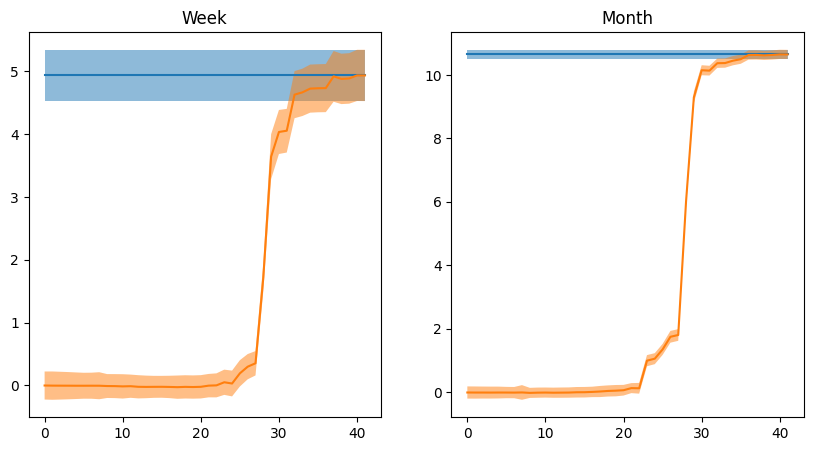

In [207]:
def average_replace_for_layer(promptfn, layer, average_residuals, confidence=0.96):
  hook    = ReplaceLayerHook(layer, promptfn.a_index, average_residuals)
  outputs = promptfn.model_outputs(hook=hook)[:, promptfn.domain_tokens]
  outputs = np.repeat(outputs, promptfn.count-1, axis=0)

  dirty_c, _, clean_c, _ = build_intervention_params(promptfn)
  dirty_logits           = outputs[np.arange(outputs.shape[0]), dirty_c]
  clean_logits           = outputs[np.arange(outputs.shape[0]), clean_c]
  deltas                 = dirty_logits - clean_logits

  mean, std_err = np.mean(deltas), scipy.stats.sem(deltas)
  band          = std_err * scipy.stats.t.ppf((1 + confidence) / 2.0, len(deltas) - 1)
  return mean-band, mean, mean+band

def plot_for_average_replace(week_average_replace, month_average_replace):
  all_layers = np.arange(model.num_hidden_layers)
  num_layers = len(all_layers)

  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].set_title('Week')
  axs[0].plot(np.repeat(week_mean, num_layers))
  axs[0].fill_between(all_layers, np.repeat(week_lower_band, num_layers), np.repeat(week_upper_band, num_layers), alpha=0.5)
  axs[0].plot(week_average_replace[:, 1])
  axs[0].fill_between(all_layers, week_average_replace[:, 0], week_average_replace[:, 2], alpha=0.5)

  axs[1].set_title('Month')
  axs[1].plot(np.repeat(month_mean, num_layers))
  axs[1].fill_between(all_layers, np.repeat(month_lower_band, num_layers), np.repeat(month_upper_band, num_layers), alpha=0.5)
  axs[1].plot(month_average_replace[:, 1])
  axs[1].fill_between(all_layers, month_average_replace[:, 0], month_average_replace[:, 2], alpha=0.5)

  plt.show()

# This takes 15mins on my machine
week_average_replace  = np.array([average_replace_for_layer(week_prompt,  i, average_residuals_week[i]) for i in range(model.num_hidden_layers)])
month_average_replace = np.array([average_replace_for_layer(month_prompt, i, average_residuals_month[i]) for i in range(model.num_hidden_layers)])

plot_for_average_replace(week_average_replace, month_average_replace)


### Replace the entire layer

We now do the most extreme intervention. We replace the entire residual stream of a layer with the average residual stream of the layer. This will form the opposite end of the no-op baseline.

In [272]:
def full_layer_replace_for_layer(promptfn, layer, token_residuals, confidence=0.96):
  def extract(prompt, a_value):
    hook = ReplaceLayerHook(layer, promptfn.a_index, token_residuals[a_value])
    return np.array(model(mx.array(tokenizer.encode(prompt))[None], hook=hook)[0, -1, promptfn.domain_tokens])

  dirty_c, clean_a, clean_c, _ = build_intervention_params(promptfn)
  outputs                      = np.array([extract(token, a_value) for token, a_value in zip(np.repeat(promptfn.prompts, promptfn.count-1), clean_a)])
  original_logits              = outputs[np.arange(outputs.shape[0]), dirty_c]
  intervention_logits          = outputs[np.arange(outputs.shape[0]), clean_c]
  deltas                       = original_logits - intervention_logits

  mean, std_err = np.mean(deltas), scipy.stats.sem(deltas)
  band          = std_err * scipy.stats.t.ppf((1 + confidence) / 2.0, len(deltas) - 1)
  return mean-band, mean, mean+band

def full_layer_replace(promptfn, layers=None, confidence=0.96):
  # FIXME: this is wrong. we need to do the full prompting, with all offsets
  zero_offset_prompts = [promptfn(i, 0) for i in range(promptfn.count)]
  token_residuals     = promptfn.hook_outputs(ExtractResidualStreamHook(promptfn.a_index), prompts=zero_offset_prompts)
  
  layers = list(layers or range(model.num_hidden_layers))
  return np.array([full_layer_replace_for_layer(promptfn, i, token_residuals[:, i], confidence) for i in tqdm(layers)])

# this takes about an hour on my machine
week_full_replace  = full_layer_replace(week_prompt)
month_full_replace = full_layer_replace(month_prompt)  ## check this again. the result is odd

100%|██████████| 42/42 [26:25<00:00, 37.74s/it]


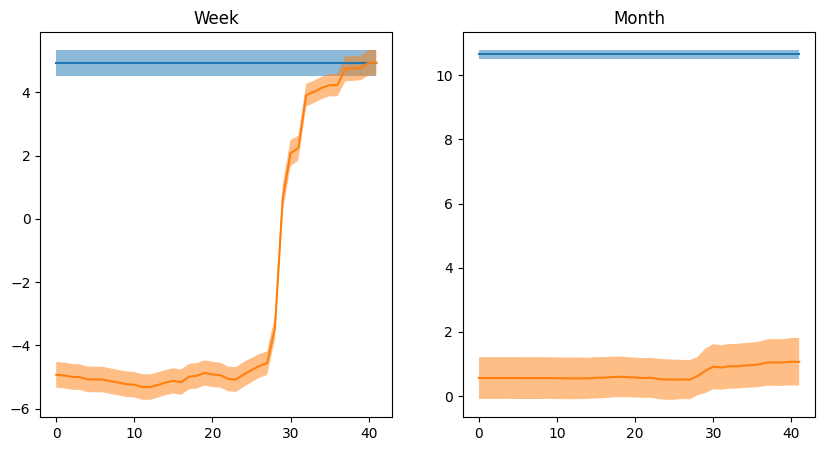

In [273]:
intervention_plot(week_full_replace, month_full_replace)

### Replace with PCA(k=5) space

In [462]:
def calc_pca_vectors(promptfn, k):
  pca_acts, pcas = extract_pca_of_residuals(promptfn, k)
  return [np.dot(a, b.components_) for a, b in zip(pca_acts, pcas)]

def pca_replace_for_layer(promptfn, layer, pca_vectors, confidence=0.96):
  def extract(prompt, pca_shift):
    hook = ReplaceLayerHook(layer, promptfn.a_index, pca_shift, op="add")
    return np.array(model(mx.array(tokenizer.encode(prompt))[None], hook=hook)[0, -1, promptfn.domain_tokens])

  dirty_c, _, clean_c, clean_i = build_intervention_params(promptfn)
  pca_shift_vectors            = pca_vectors[clean_i] - pca_vectors[np.repeat(range(promptfn.count*promptfn.count), promptfn.count-1)]

  outputs      = np.array([extract(token, pca_shift) for token, pca_shift in zip(np.repeat(promptfn.prompts, promptfn.count-1), pca_shift_vectors)])
  dirty_logits = outputs[np.arange(outputs.shape[0]), dirty_c]
  clean_logits = outputs[np.arange(outputs.shape[0]), clean_c]
  deltas       = dirty_logits - clean_logits

  mean, std_err = np.mean(deltas), scipy.stats.sem(deltas)
  band          = std_err * scipy.stats.t.ppf((1 + confidence) / 2.0, len(deltas) - 1)
  return mean-band, mean, mean+band

def pca_replace(promptfn, layers=None, confidence=0.96):
  pca_vectors = calc_pca_vectors(promptfn, 5)
  layers      = list(layers or range(model.num_hidden_layers))
  return np.array([pca_replace_for_layer(promptfn, i, pca_vectors[i], confidence) for i in tqdm(layers)])

week_pca_replace  = pca_replace(week_prompt)
month_pca_replace = pca_replace(month_prompt)

100%|██████████| 42/42 [2:08:25<00:00, 183.47s/it]  


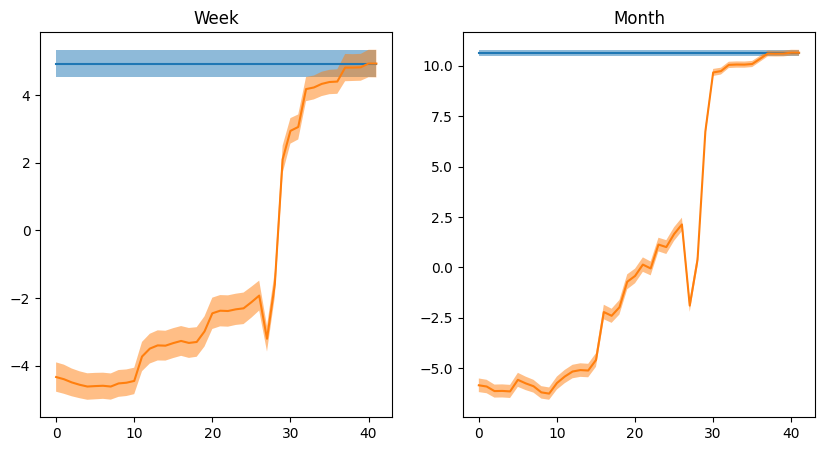

In [463]:
intervention_plot(week_pca_replace, month_pca_replace)

### Replace with projection from circle

Finally the most interesting intervention. We use the linear probe, ie the circle we trained to find where the patched activation should go. This is similar to the previous step, but this time we explicitly test whether the circular representation is causally connected to the output token.

In [567]:
def calc_circle_embeds(promptfn, linear_probes, circle=None):
  if circle is None:
    w       = 2 * np.pi / promptfn.count
    circle  = np.array([np.cos(w * np.arange(promptfn.count)), np.sin(w * np.arange(promptfn.count))]).T

  from sklearn.decomposition import PCA
  residuals  = np.transpose(extract_residual_streams(promptfn), (1, 0, 2))
  layer_avgs = np.mean(residuals, axis=1)
  pcas       = np.array([PCA(n_components=5).fit(residual) for residual in residuals])

  def project_circle(layer_avg, pca, linear_probe):
    q, r        = np.linalg.qr(linear_probe)
    circle_comp = circle @ np.linalg.inv(r) @ q.T @ pca.components_
    avg_comp    = layer_avg @ pca.components_.T @ q @ q.T @ pca.components_
    return layer_avg + (circle_comp - avg_comp)
  return list(starmap(project_circle, zip(layer_avgs, pcas, linear_probes)))

In [506]:
def circle_replace_for_layer(promptfn, layer, circle_embed, confidence=0.96):
  def extract(prompt, circle_embed):
    hook = ReplaceLayerHook(layer, promptfn.a_index, circle_embed)
    return np.array(model(mx.array(tokenizer.encode(prompt))[None], hook=hook)[0, -1, promptfn.domain_tokens])

  dirty_c, _, clean_c, clean_i = build_intervention_params(promptfn)

  outputs      = np.array([extract(token, pca_shift) for token, pca_shift in zip(np.repeat(promptfn.prompts, promptfn.count-1), circle_embed[clean_i])])
  dirty_logits = outputs[np.arange(outputs.shape[0]), dirty_c]
  clean_logits = outputs[np.arange(outputs.shape[0]), clean_c]
  deltas       = dirty_logits - clean_logits

  mean, std_err = np.mean(deltas), scipy.stats.sem(deltas)
  band          = std_err * scipy.stats.t.ppf((1 + confidence) / 2.0, len(deltas) - 1)
  return mean-band, mean, mean+band

def circle_replace(promptfn, layers=None, confidence=0.96):
  linear_probes = train_linear_probes(promptfn)[0]
  circle_embeds = calc_circle_embeds(promptfn, linear_probes)
  layers        = list(layers or range(model.num_hidden_layers))
  return np.array([pca_replace_for_layer(promptfn, i, circle_embeds[i], confidence) for i in tqdm(layers)])

week_circle_replace  = circle_replace(week_prompt)
month_circle_replace = circle_replace(month_prompt)

100%|██████████| 42/42 [2:00:51<00:00, 172.66s/it]  


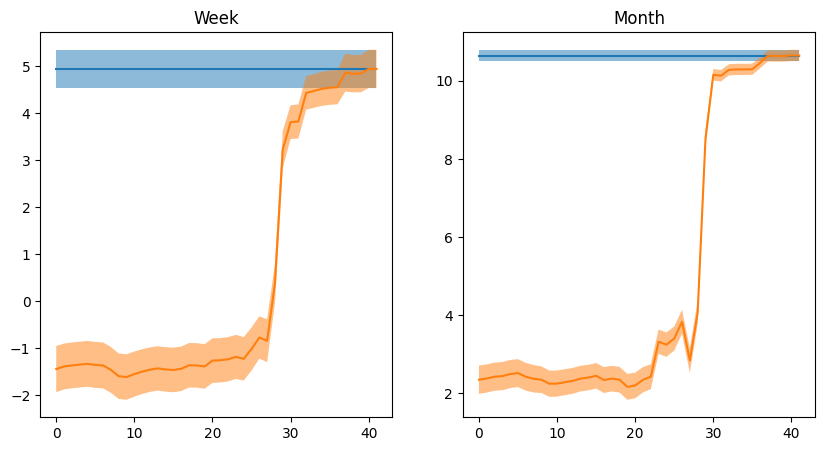

In [507]:
intervention_plot(week_circle_replace, month_circle_replace)

### Putting it all together

* Draw all interventions in one plot
* describe the argument why this shows that the circular representation is causally connected to the output token

## Off-distribution experiments

We investigate in more detail how the circular representations are used. in the activation patching only the circumference of the circle  was used. Now investigate the "inside" of the circle.

In [575]:
def circle_points(num):
  rs     = 2*(np.linspace(0, 1, num)**0.8)
  phis   = np.linspace(0, 2*np.pi, num)
  grid   = np.meshgrid(rs, phis)
  x      = (grid[0] * np.cos(grid[1])).reshape(-1)
  y      = (grid[0] * np.sin(grid[1])).reshape(-1)
  return np.column_stack((x, y))

def highest_logit_in_filled_circle_for_layer_and_offset(promptfn, layer, offset, embeds):
  def extract(prompt, circle_embed):
    hook = ReplaceLayerHook(layer, promptfn.a_index, circle_embed)
    return np.array(model(mx.array(tokenizer.encode(prompt))[None], hook=hook)[0, -1, promptfn.domain_tokens])
  
  outputs = np.array([extract(promptfn(0, offset), circle_embed) for circle_embed in embeds])
  return outputs.argmax(axis=1)

def highest_logit_in_filled_circle_for_layer(promptfn, layer, circle):
  probes = train_linear_probes(promptfn)[0]
  embeds = calc_circle_embeds(promptfn, probes, circle=circle)
  return [highest_logit_in_filled_circle_for_layer_and_offset(promptfn, layer, i, embeds[layer]) for i in tqdm(range(promptfn.count))]

circle = circle_points(200)
week_filled_circle_layer10 = highest_logit_in_filled_circle_for_layer(week_prompt, 10, circle)

100%|██████████| 7/7 [9:16:40<00:00, 4771.48s/it]  


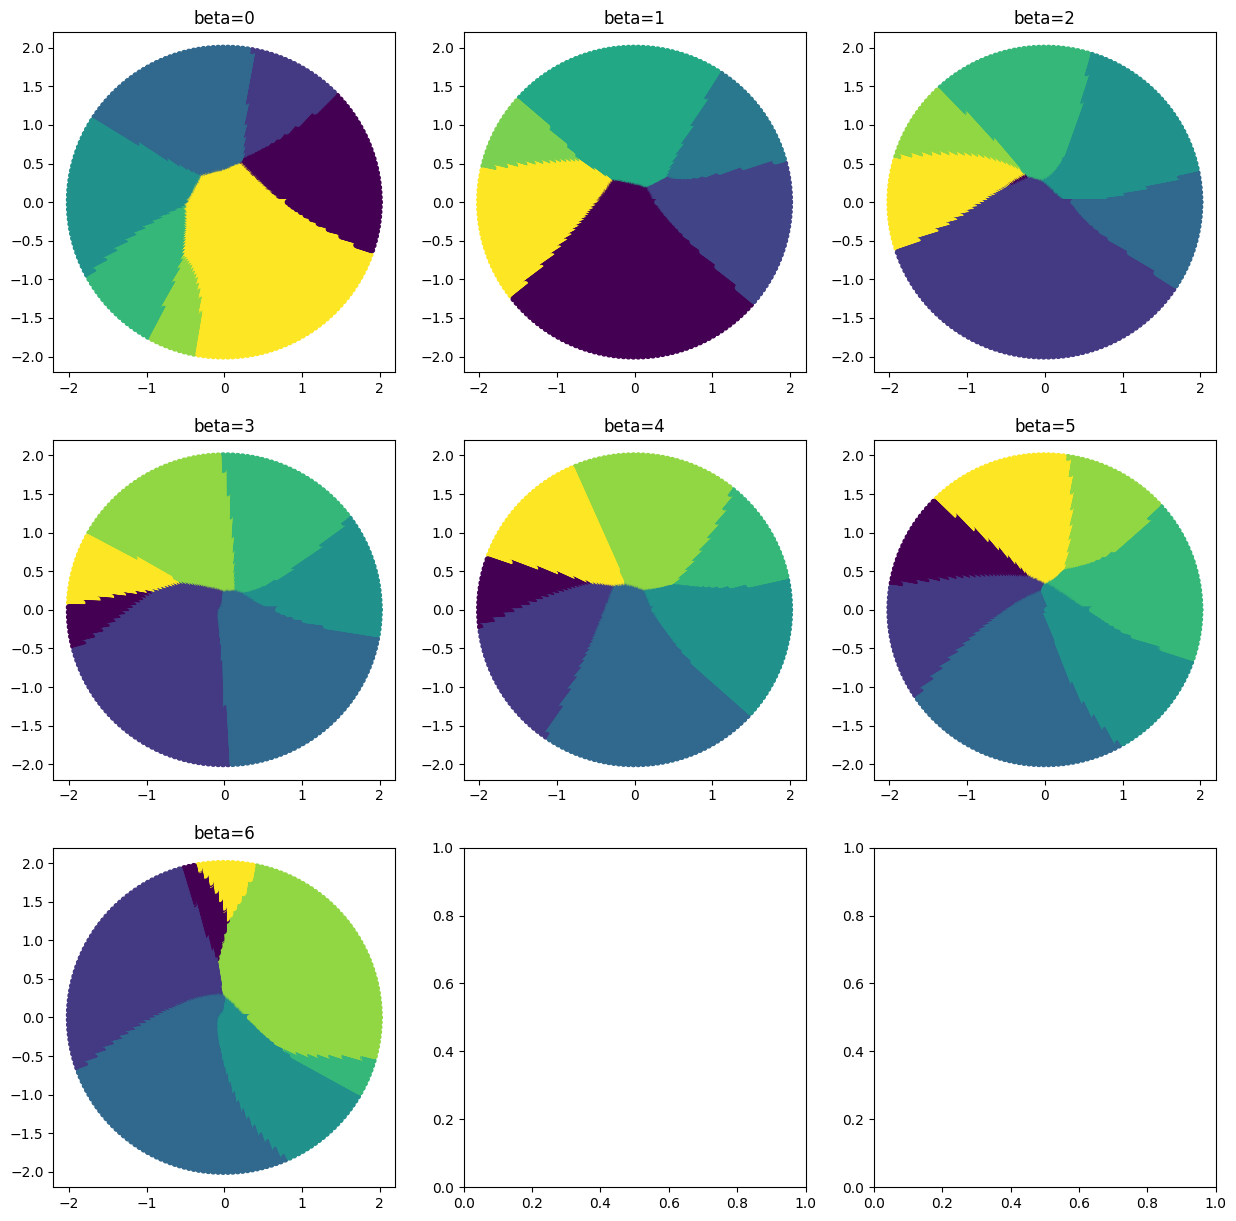

In [584]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, (layer, ax) in enumerate(zip(week_filled_circle_layer10, axs.flatten())):
  ax.scatter(circle[:, 0], circle[:, 1], c=layer, s=12)
  ax.title.set_text(f"beta={i}")
plt.show()

# Discussion & Some ideas for further work

What's missing:
* it documents a method to evaluate to what extent a feature is reducible or a mixture
* the layer in which the circuit performing the modular arithmetic resides is located
* a method which explains the circuit in terms of mathematical functions is developed